In [1]:
%pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [48]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


## Librerias y cargar dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

2024-01-23 13:13:09.180745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 13:13:09.829556: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-23 13:13:09.829599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-23 13:13:09.829605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Codigo

Variables iniciales para correr el codigo

In [3]:
rowsTraining = 61
colsTraining = 180
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4

parte0_0 = "Part0_0"
parte0_1 = "Part0_1"
parte1_0 = "Part1_0"
parte1_1 = "Part1_1"

imagenInicial = 300

# Unir 2X2

Aqui se une la imagen completa con los bordes nuevos 2X2

data 00 (370, 9, 61, 180, 1)
data 01 (370, 9, 61, 190, 1)
data 10 (370, 9, 71, 180, 1)
data 11 (370, 9, 71, 190, 1)
data 00 (370, 9, 61, 176, 1)
data 01 (370, 9, 61, 184, 1)
La forma de los datos combinados es: (370, 9, 61, 360, 1)


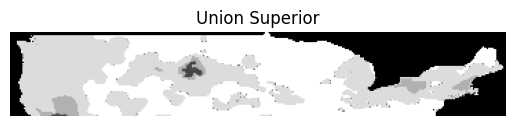

In [3]:
#                  DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_180Part0_0/PredictionsConvolutionLSTM_forecast_61_180_Part0_0_w10.npy
data0_0 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_180Part0_0/PredictionsConvolutionLSTM_forecast_61_180_Part0_0_w10.npy")
data0_1 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_190Part0_1/PredictionsConvolutionLSTM_forecast_61_190_Part0_1_w10.npy")
data1_0 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_180Part1_0/PredictionsConvolutionLSTM_forecast_71_180_Part1_0_w10.npy")
data1_1 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_190Part1_1/PredictionsConvolutionLSTM_forecast_71_190_Part1_1_w10.npy")
print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
print("data 10",data1_0.shape)
print("data 11",data1_1.shape)

# Asegúrate de que las dimensiones de tus arrays son las que esperas
assert data0_0.shape[3] == 180, "La forma de data0_0 no es la esperada"
assert data0_1.shape[3] == 190, "La forma de data0_1 no es la esperada"

# Recortar 5 pixeles de cada lado
data0_0 = data0_0[:, :, :, :-4, :]
data0_1 = data0_1[:, :, :, 6:, :]
print("data 00",data0_0.shape)
print("data 01",data0_1.shape)

#concatena los datos
combined_data0 = np.concatenate((data0_0, data0_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data0[0,0], cmap='gray')
plt.title("Union Superior")
plt.axis('off')
plt.show()

data 10 (370, 9, 71, 180, 1)
data 11 (370, 9, 71, 190, 1)
data 10 (370, 9, 71, 176, 1)
data 11 (370, 9, 71, 184, 1)
La forma de los datos combinados es: (370, 9, 71, 360, 1)


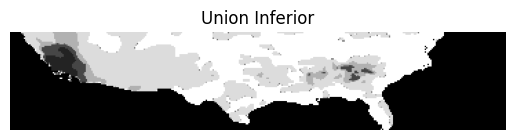

In [4]:
data1_0 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_180Part1_0/PredictionsConvolutionLSTM_forecast_71_180_Part1_0_w10.npy")
data1_1 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_190Part1_1/PredictionsConvolutionLSTM_forecast_71_190_Part1_1_w10.npy")

print("data 10",data1_0.shape)
print("data 11",data1_1.shape)
data1_0 = data1_0[:, :, :,:-4, :]
data1_1 = data1_1[:, :, :, 6:, :]
print("data 10",data1_0.shape)
print("data 11",data1_1.shape)

#concatena los datos
combined_data1 = np.concatenate((data1_0, data1_1), axis=3)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data1.shape)

plt.imshow(combined_data1[0,0], cmap='gray')
plt.title("Union Inferior")
plt.axis('off')
plt.show()

data 00 (370, 9, 57, 360, 1)
data 01 (370, 9, 65, 360, 1)
La forma de los datos combinados es: (370, 9, 122, 360, 1)


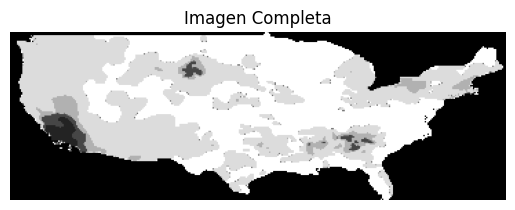

In [5]:
combined_data0 = combined_data0[:, :, :-4, :, ]
combined_data1 = combined_data1[:, :, 6:, :, ]
print("data 00",combined_data0.shape)
print("data 01",combined_data1.shape)

#concatena los datos
combined_data = np.concatenate((combined_data0, combined_data1), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data.shape)

plt.imshow(combined_data[0,0], cmap='gray')
plt.title("Imagen Completa")
plt.axis('off')
plt.show()

# Guardar el array combinado
np.save("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/imageComplete.npy", combined_data)

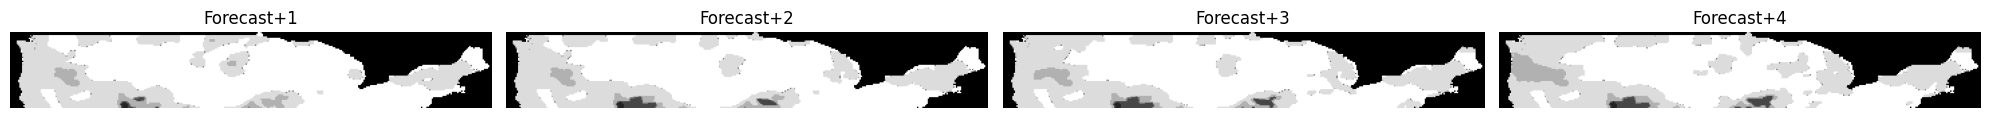

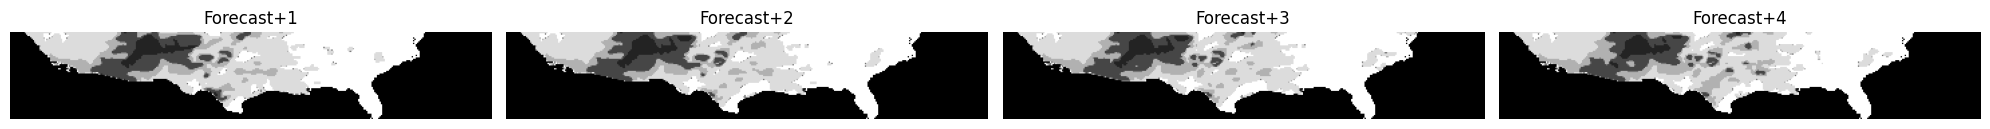

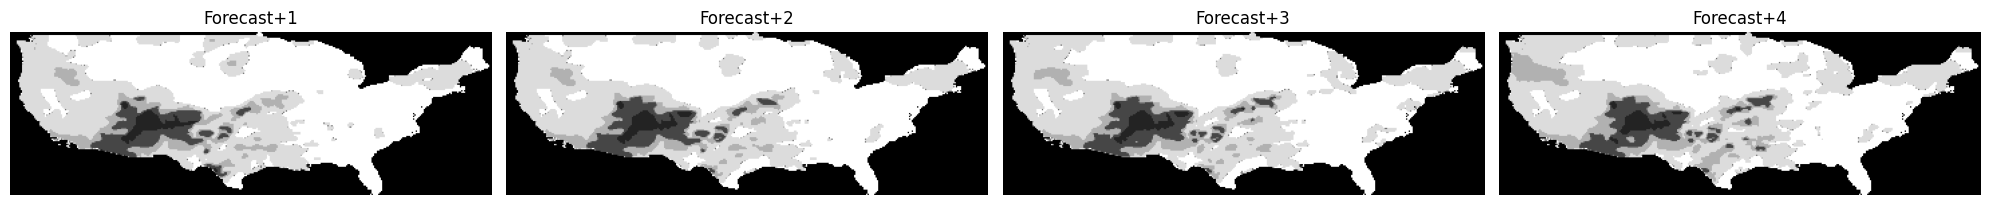

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100

for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data0[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data1[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

concatenar los xtest y ytest


In [9]:
x_test00 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_180Part0_0/x_test_mask.npy")
x_test01 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_190Part0_1/x_test_mask.npy")
x_test10 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_180Part1_0/x_test_mask.npy")
x_test11 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_190Part1_1/x_test_mask.npy")

x_test00 = x_test00[:, :, :, :-4, :]
x_test01 = x_test01[:, :, :, 6:, :]

x_test10 = x_test10[:, :, :,:-4, :]
x_test11 = x_test11[:, :, :, 6:, :]

combined_x_test0 = np.concatenate((x_test00, x_test01), axis=3)

combined_x_test1 = np.concatenate((x_test10, x_test11), axis=3)

combined_x_test0 = combined_x_test0[:, :, :-4, :, ]
combined_x_test1 = combined_x_test1[:, :, 6:, :, ]
print("data 00",combined_x_test0.shape)
print("data 01",combined_x_test1.shape)

#concatena los datos
combined_x_test = np.concatenate((combined_x_test0, combined_x_test1), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_x_test.shape)

np.save("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/x_test_mask.npy", combined_x_test)

data 00 (370, 9, 57, 360, 1)
data 01 (370, 9, 65, 360, 1)
La forma de los datos combinados es: (370, 9, 122, 360, 1)


In [10]:
y_test00 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_180Part0_0/y_test_mask.npy")
y_test01 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/61_190Part0_1/y_test_mask.npy")
y_test10 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_180Part1_0/y_test_mask.npy")
y_test11 = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/71_190Part1_1/y_test_mask.npy")

print("y_test00",y_test00.shape)
print("y_test01",y_test01.shape)
print("y_test10",y_test10.shape)
print("y_test11",y_test11.shape)

y_test00 = y_test00[:, :,:-4, :]
y_test01 = y_test01[:, :, 6:, :]
print("shape00",y_test00.shape)
print("shape01",y_test01.shape)

y_test10 = y_test10[:, :,:-4, :]
y_test11 = y_test11[:, :, 6:, :]

combined_y_test0 = np.concatenate((y_test00, y_test01), axis=2)

combined_y_test1 = np.concatenate((y_test10, y_test11), axis=2)

combined_y_test0 = combined_y_test0[:, :-4, :, ]

combined_y_test1 = combined_y_test1[:, 6:, :, ]

print("data 00",combined_y_test0.shape)
print("data 01",combined_y_test1.shape)

#concatena los datos
combined_y_test = np.concatenate((combined_y_test0, combined_y_test1), axis=1)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_y_test.shape)

np.save("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/y_test_mask.npy", combined_y_test)


y_test00 (370, 61, 180, 1)
y_test01 (370, 61, 190, 1)
y_test10 (370, 71, 180, 1)
y_test11 (370, 71, 190, 1)
shape00 (370, 61, 176, 1)
shape01 (370, 61, 184, 1)
data 00 (370, 57, 360, 1)
data 01 (370, 65, 360, 1)
La forma de los datos combinados es: (370, 122, 360, 1)


In [11]:
data = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/imageComplete.npy")
x_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/x_test_mask.npy")
y_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/y_test_mask.npy")

In [12]:
print("data",data.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

data (370, 9, 122, 360, 1)
x_test (370, 9, 122, 360, 1)
y_test (370, 122, 360, 1)


# Unir 3X3

## Union imagen completa

In [34]:


#print("data 00",data0_0.shape)
#print("data 01",data0_1.shape)
#print("data 02",data0_2.shape)
#print("data 10",data1_0.shape)
#print("data 11",data1_1.shape)
#print("data 12",data1_2.shape)
#print("data 20",data2_0.shape)
#print("data 21",data2_1.shape)
#print("data 22",data2_2.shape)
#
## Asegúrate de que las dimensiones de tus arrays son las que esperas
#assert data0_0.shape[3] == 120, "La forma de data0_0 no es la esperada"
#assert data0_1.shape[3] == 130, "La forma de data0_1 no es la esperada"

carpeta3x3 = "v4w22"
ventana3x3 = "22"

Union sueperior

data 00 (370, 21, 41, 120, 1)
data 01 (370, 21, 41, 130, 1)
data 00 recortada (370, 21, 41, 116, 1)
data 01 recortada (370, 21, 41, 124, 1)
La forma de los datos combinados es: (370, 21, 41, 240, 1)
combined_data0 recortada (370, 21, 41, 236, 1)
data 02 recortada (370, 21, 41, 124, 1)
La forma de los datos combinados es: (370, 21, 41, 360, 1)


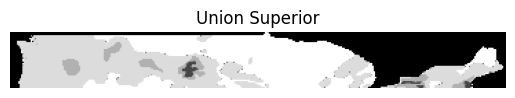

In [16]:
data0_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_120Part0_0/PredictionsConvolutionLSTM_forecast_41_120_Part0_0_w"+ventana3x3+".npy")
data0_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_130Part0_1/PredictionsConvolutionLSTM_forecast_41_130_Part0_1_w"+ventana3x3+".npy")
data0_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_130Part0_2/PredictionsConvolutionLSTM_forecast_41_130_Part0_2_w"+ventana3x3+".npy")

print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
data0_0 = data0_0[:, :, :, :-4, :] # recorte del lado derecho
data0_1 = data0_1[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data0_0.shape)
print("data 01 recortada",data0_1.shape)

#concatena los datos
combined_data0_1 = np.concatenate((data0_0, data0_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0_1.shape)

combined_data0_1 = combined_data0_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data0_1.shape)

data0_2 = data0_2[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data0_2.shape)

#concatena los datos
combined_data0_2 = np.concatenate((combined_data0_1, data0_2), axis=3)

# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data0_2.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data0_2[0,0], cmap='gray')
plt.title("Union Superior")
plt.axis('off')
plt.show()

union Intermedia

data1_0 (370, 21, 51, 120, 1)
data1_1 (370, 21, 51, 130, 1)
data 00 recortada (370, 21, 51, 116, 1)
data 01 recortada (370, 21, 51, 124, 1)
La forma de los datos combinados es: (370, 21, 51, 240, 1)
combined_data0 recortada (370, 21, 51, 236, 1)
data 02 recortada (370, 21, 51, 124, 1)
La forma de los datos combinados es: (370, 21, 51, 360, 1)


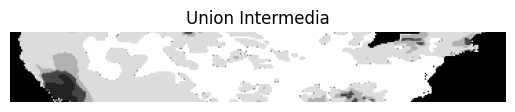

In [17]:

data1_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_120Part1_0/PredictionsConvolutionLSTM_forecast_51_120_Part1_0_w"+ventana3x3+".npy")
data1_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part1_1/PredictionsConvolutionLSTM_forecast_51_130_Part1_1_w"+ventana3x3+".npy")
data1_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part1_2/PredictionsConvolutionLSTM_forecast_51_130_Part1_2_w"+ventana3x3+".npy")

print("data1_0",data1_0.shape)
print("data1_1",data1_1.shape)
data1_0 = data1_0[:, :, :, :-4, :] # recorte del lado derecho
data1_1 = data1_1[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data1_0.shape)
print("data 01 recortada",data1_1.shape)

#concatena los datos
combined_data1_1 = np.concatenate((data1_0, data1_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data1_1.shape)

combined_data1_1 = combined_data1_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data1_1.shape)

data1_2 = data1_2[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data1_2.shape)

#concatena los datos
combined_data1_2 = np.concatenate((combined_data1_1, data1_2), axis=3)

# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data1_2.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data1_2[0,0], cmap='gray')
plt.title("Union Intermedia")
plt.axis('off')
plt.show()

Union inferior

data2_0 (370, 21, 51, 120, 1)
data2_1 (370, 21, 51, 130, 1)
data 00 recortada (370, 21, 51, 116, 1)
data 01 recortada (370, 21, 51, 124, 1)
La forma de los datos combinados es: (370, 21, 51, 240, 1)
combined_data0 recortada (370, 21, 51, 236, 1)
data 02 recortada (370, 21, 51, 124, 1)
La forma de los datos combinados es: (370, 21, 51, 360, 1)


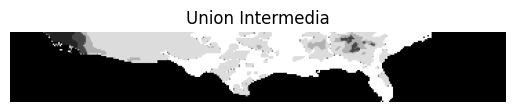

In [19]:

data2_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_120Part2_0/PredictionsConvolutionLSTM_forecast_51_120_Part2_0_w"+ventana3x3+".npy")
data2_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part2_1/PredictionsConvolutionLSTM_forecast_51_130_Part2_1_w"+ventana3x3+".npy")
data2_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part2_2/PredictionsConvolutionLSTM_forecast_51_130_Part2_2_w"+ventana3x3+".npy")

print("data2_0",data2_0.shape)
print("data2_1",data2_1.shape)
data2_0 = data2_0[:, :, :, :-4, :] # recorte del lado derecho
data2_1 = data2_1[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data2_0.shape)
print("data 01 recortada",data2_1.shape)

#concatena los datos
combined_data2_1 = np.concatenate((data2_0, data2_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data2_1.shape)

combined_data2_1 = combined_data2_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data2_1.shape)

data2_2 = data2_2[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data2_2.shape)

#concatena los datos
combined_data2_2 = np.concatenate((combined_data2_1, data2_2), axis=3)

# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data2_2.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data2_2[0,0], cmap='gray')
plt.title("Union Intermedia")
plt.axis('off')
plt.show()

Union imagen Top y Mid

data 00 (370, 21, 37, 360, 1)
data 01 (370, 21, 45, 360, 1)
La forma de los datos combinados es: (370, 21, 82, 360, 1)


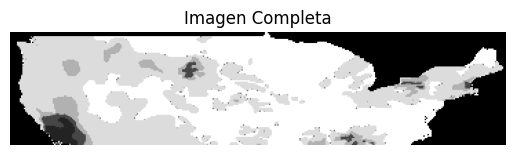

In [20]:
combined_data0_2 = combined_data0_2[:, :, :-4, :, ]
combined_data1_2 = combined_data1_2[:, :, 6:, :, ]
print("data 00",combined_data0_2.shape)
print("data 01",combined_data1_2.shape)

#concatena los datos
combined_data3x3TopMid = np.concatenate((combined_data0_2, combined_data1_2), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data3x3TopMid.shape)

plt.imshow(combined_data3x3TopMid[0,0], cmap='gray')
plt.title("Imagen Completa")
plt.axis('off')
plt.show()

# Guardar el array combinado
#np.save("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/imageComplete.npy", combined_data)

Union imagen TopMid con Bot

data 00 (370, 21, 78, 360, 1)
data 01 (370, 21, 44, 360, 1)
La forma de los datos combinados es: (370, 21, 122, 360, 1)


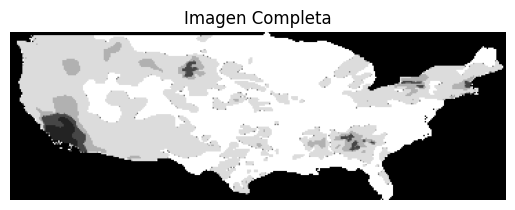

In [21]:

combined_data3x3TopMid = combined_data3x3TopMid[:, :, :-4, :, ]
combined_data2_2 = combined_data2_2[:, :, 7:, :, ]
print("data 00",combined_data3x3TopMid.shape)
print("data 01",combined_data2_2.shape)

#concatena los datos
combined_data3x3TopMidBot = np.concatenate((combined_data3x3TopMid, combined_data2_2), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data3x3TopMidBot.shape)

plt.imshow(combined_data3x3TopMidBot[0,0], cmap='gray')
plt.title("Imagen Completa")
plt.axis('off')
plt.show()

# Guardar el array combinado
#np.save("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/imageComplete.npy", combined_data)

In [22]:
# Guardar el array combinado
np.save("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/imageComplete3x3"+carpeta3x3+".npy", combined_data3x3TopMidBot)

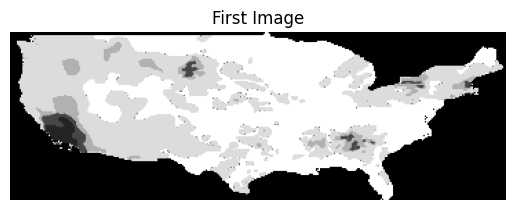

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy array
combined_data = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/imageComplete3x3"+carpeta3x3+".npy")

# Display the first image
plt.imshow(combined_data[0, 0], cmap='gray')
plt.title("First Image")
plt.axis('off')
plt.show()

Mostrar el avance de las uniones

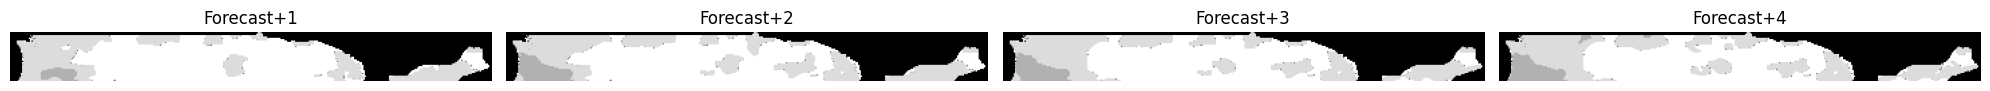

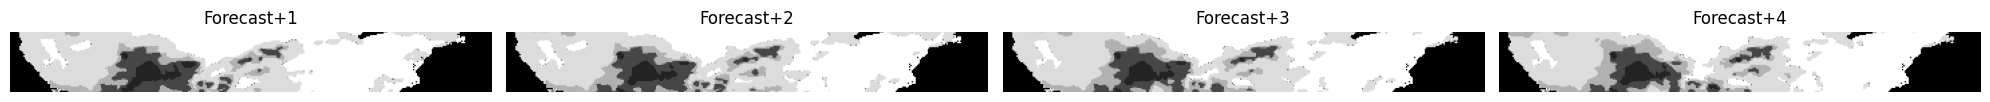

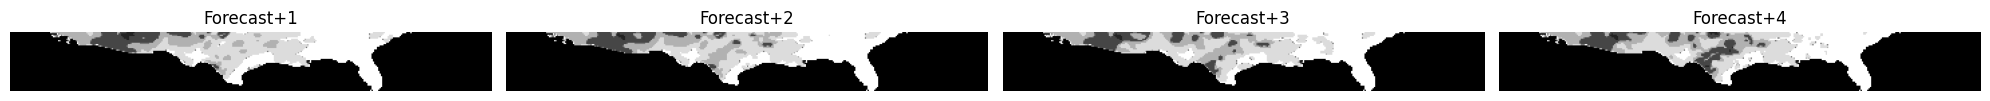

In [42]:

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
horizon = 4

for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data0_2[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data1_2[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data2_2[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

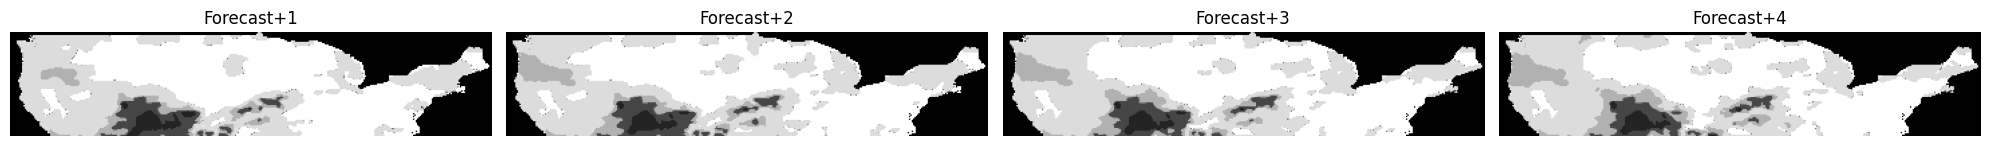

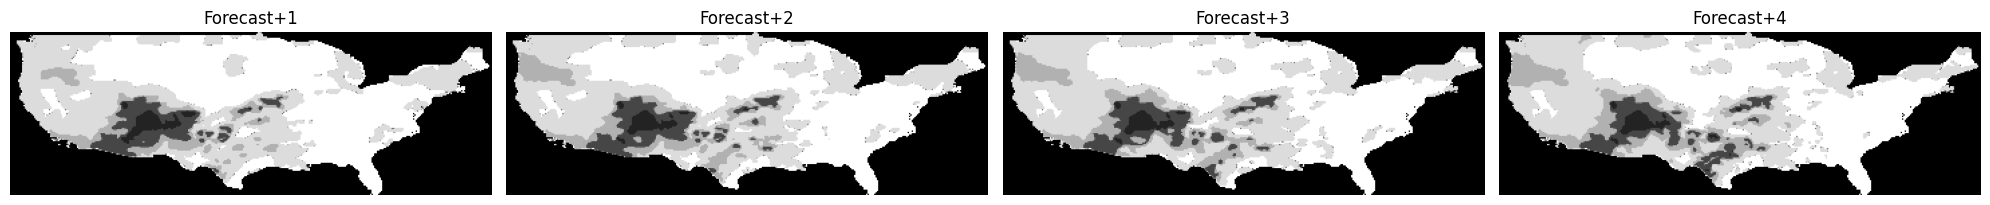

In [43]:

fig = plt.figure(figsize=(20,20))
r = 2
c = 4
ac = 1
pos = 100

for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data3x3TopMid[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(combined_data3x3TopMidBot[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Forecast+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()



## Creacion de xtest y ytest

#### Crear xtest

In [31]:
data0_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_120Part0_0/x_test_mask.npy")
data0_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_130Part0_1/x_test_mask.npy")
data0_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_130Part0_2/x_test_mask.npy")

print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
data0_0 = data0_0[:, :, :, :-4, :] # recorte del lado derecho
data0_1 = data0_1[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data0_0.shape)
print("data 01 recortada",data0_1.shape)

#concatena los datos
combined_data0_1 = np.concatenate((data0_0, data0_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0_1.shape)

combined_data0_1 = combined_data0_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data0_1.shape)

data0_2 = data0_2[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data0_2.shape)

#concatena los datos
combined_data0_2 = np.concatenate((combined_data0_1, data0_2), axis=3)

####

data1_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_120Part1_0/x_test_mask.npy")
data1_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part1_1/x_test_mask.npy")
data1_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part1_2/x_test_mask.npy")

print("data1_0",data1_0.shape)
print("data1_1",data1_1.shape)
data1_0 = data1_0[:, :, :, :-4, :] # recorte del lado derecho
data1_1 = data1_1[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data1_0.shape)
print("data 01 recortada",data1_1.shape)

#concatena los datos
combined_data1_1 = np.concatenate((data1_0, data1_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data1_1.shape)

combined_data1_1 = combined_data1_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data1_1.shape)

data1_2 = data1_2[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data1_2.shape)

#concatena los datos
combined_data1_2 = np.concatenate((combined_data1_1, data1_2), axis=3)

####

data2_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_120Part2_0/x_test_mask.npy")
data2_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part2_1/x_test_mask.npy")
data2_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part2_2/x_test_mask.npy")
print ("data 2_2", data2_2.shape)
print("data2_0",data2_0.shape)
print("data2_1",data2_1.shape)
data2_0 = data2_0[:, :, :, :-4, :] # recorte del lado derecho
data2_1 = data2_1[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data2_0.shape)
print("data 01 recortada",data2_1.shape)

#concatena los datos
combined_data2_1 = np.concatenate((data2_0, data2_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data2_1.shape)

combined_data2_1 = combined_data2_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data2_1.shape)

data2_2 = data2_2[:, :, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data2_2.shape)

#concatena los datos
combined_data2_2 = np.concatenate((combined_data2_1, data2_2), axis=3)

####

combined_data0_2 = combined_data0_2[:, :, :-4, :, ]
combined_data1_2 = combined_data1_2[:, :, 6:, :, ]
print("data 00",combined_data0_2.shape)
print("data 01",combined_data1_2.shape)

#concatena los datos
combined_data3x3TopMid = np.concatenate((combined_data0_2, combined_data1_2), axis=2)

####

combined_data3x3TopMid = combined_data3x3TopMid[:, :, :-4, :, ]
combined_data2_2 = combined_data2_2[:, :, 7:, :, ]
print("data 00",combined_data3x3TopMid.shape)
print("data 01",combined_data2_2.shape)

#concatena los datos
combined_data3x3TopMidBot = np.concatenate((combined_data3x3TopMid, combined_data2_2), axis=2)

####
print ("combined_data3x3TopMidBot", combined_data3x3TopMidBot.shape)

# Guardar el array combinado
np.save("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/x_test_mask_imageComplete"+carpeta3x3+".npy", combined_data3x3TopMidBot)

data 00 (370, 21, 41, 120, 1)
data 01 (370, 21, 41, 130, 1)
data 00 recortada (370, 21, 41, 116, 1)
data 01 recortada (370, 21, 41, 124, 1)
La forma de los datos combinados es: (370, 21, 41, 240, 1)
combined_data0 recortada (370, 21, 41, 236, 1)
data 02 recortada (370, 21, 41, 124, 1)
data1_0 (370, 21, 51, 120, 1)
data1_1 (370, 21, 51, 130, 1)
data 00 recortada (370, 21, 51, 116, 1)
data 01 recortada (370, 21, 51, 124, 1)
La forma de los datos combinados es: (370, 21, 51, 240, 1)
combined_data0 recortada (370, 21, 51, 236, 1)
data 02 recortada (370, 21, 51, 124, 1)
data 2_2 (370, 21, 51, 130, 1)
data2_0 (370, 21, 51, 120, 1)
data2_1 (370, 21, 51, 130, 1)
data 00 recortada (370, 21, 51, 116, 1)
data 01 recortada (370, 21, 51, 124, 1)
La forma de los datos combinados es: (370, 21, 51, 240, 1)
combined_data0 recortada (370, 21, 51, 236, 1)
data 02 recortada (370, 21, 51, 124, 1)
data 00 (370, 21, 37, 360, 1)
data 01 (370, 21, 45, 360, 1)
data 00 (370, 21, 78, 360, 1)
data 01 (370, 21, 44,

#### Crear ytest

In [28]:
data0_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_120Part0_0/y_test_mask.npy")
data0_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_130Part0_1/y_test_mask.npy")
data0_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/41_130Part0_2/y_test_mask.npy")

print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
data0_0 = data0_0[:, :, :-4, :] # recorte del lado derecho
data0_1 = data0_1[:, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data0_0.shape)
print("data 01 recortada",data0_1.shape)

#concatena los datos
combined_data0_1 = np.concatenate((data0_0, data0_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0_1.shape)

combined_data0_1 = combined_data0_1[:, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data0_1.shape)

data0_2 = data0_2[:, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data0_2.shape)

#concatena los datos
combined_data0_2 = np.concatenate((combined_data0_1, data0_2), axis=2)

####

data1_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_120Part1_0/y_test_mask.npy")
data1_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part1_1/y_test_mask.npy")
data1_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part1_2/y_test_mask.npy")

print("data1_0",data1_0.shape)
print("data1_1",data1_1.shape)
data1_0 = data1_0[:, :, :-4, :] # recorte del lado derecho
data1_1 = data1_1[:, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data1_0.shape)
print("data 01 recortada",data1_1.shape)

#concatena los datos
combined_data1_1 = np.concatenate((data1_0, data1_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data1_1.shape)

combined_data1_1 = combined_data1_1[:, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data1_1.shape)

data1_2 = data1_2[:, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data1_2.shape)

#concatena los datos
combined_data1_2 = np.concatenate((combined_data1_1, data1_2), axis=2)

####

data2_0 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_120Part2_0/y_test_mask.npy")
data2_1 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part2_1/y_test_mask.npy")
data2_2 = np.load("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/51_130Part2_2/y_test_mask.npy")
print ("data 2_2", data2_2.shape)
print("data2_0",data2_0.shape)
print("data2_1",data2_1.shape)
data2_0 = data2_0[:, :, :-4, :] # recorte del lado derecho
data2_1 = data2_1[:, :, 6:, :] # recorte del lado izquierdo
print("data 00 recortada",data2_0.shape)
print("data 01 recortada",data2_1.shape)

#concatena los datos
combined_data2_1 = np.concatenate((data2_0, data2_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data2_1.shape)

combined_data2_1 = combined_data2_1[:, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data2_1.shape)

data2_2 = data2_2[:, :, 6:, :] # recorte del lado izquierdo
print("data 02 recortada",data2_2.shape)

#concatena los datos
combined_data2_2 = np.concatenate((combined_data2_1, data2_2), axis=2)

####

combined_data0_2 = combined_data0_2[:, :-4, :, ]
combined_data1_2 = combined_data1_2[:, 6:, :, ]
print("data 00",combined_data0_2.shape)
print("data 01",combined_data1_2.shape)

#concatena los datos
combined_data3x3TopMid = np.concatenate((combined_data0_2, combined_data1_2), axis=1)

####

combined_data3x3TopMid = combined_data3x3TopMid[:, :-4, :, ]
combined_data2_2 = combined_data2_2[:, 7:, :, ]
print("data 00",combined_data3x3TopMid.shape)
print("data 01",combined_data2_2.shape)

#concatena los datos
combined_data3x3TopMidBot = np.concatenate((combined_data3x3TopMid, combined_data2_2), axis=1)

####
print ("combined_data3x3TopMidBot", combined_data3x3TopMidBot.shape)

# Guardar el array combinado
np.save("DroughtDatasetMask/dataset/Resultados3x3/"+carpeta3x3+"/y_test_mask_imageComplete"+carpeta3x3+".npy", combined_data3x3TopMidBot)

data 00 (370, 41, 120, 1)
data 01 (370, 41, 130, 1)
data 00 recortada (370, 41, 116, 1)
data 01 recortada (370, 41, 124, 1)
La forma de los datos combinados es: (370, 41, 240, 1)
combined_data0 recortada (370, 41, 236, 1)
data 02 recortada (370, 41, 124, 1)
data1_0 (370, 51, 120, 1)
data1_1 (370, 51, 130, 1)
data 00 recortada (370, 51, 116, 1)
data 01 recortada (370, 51, 124, 1)
La forma de los datos combinados es: (370, 51, 240, 1)
combined_data0 recortada (370, 51, 236, 1)
data 02 recortada (370, 51, 124, 1)
data 2_2 (370, 51, 130, 1)
data2_0 (370, 51, 120, 1)
data2_1 (370, 51, 130, 1)
data 00 recortada (370, 51, 116, 1)
data 01 recortada (370, 51, 124, 1)
La forma de los datos combinados es: (370, 51, 240, 1)
combined_data0 recortada (370, 51, 236, 1)
data 02 recortada (370, 51, 124, 1)
data 00 (370, 37, 360, 1)
data 01 (370, 45, 360, 1)
data 00 (370, 78, 360, 1)
data 01 (370, 44, 360, 1)
combined_data3x3TopMidBot (370, 122, 360, 1)


# Unir 4X4

## Union de imagen completa

In [35]:
carpeta4x4 = "v8w22"

ventana4x4 = "22"

data 00 (370, 21, 31, 90, 1)
data 01 (370, 21, 31, 100, 1)
data 00 recortada (370, 21, 31, 86, 1)
data 01 recortada (370, 21, 31, 93, 1)
La forma de los datos combinados es: (370, 21, 31, 179, 1)
combined_data0 recortada (370, 21, 31, 175, 1)
data 02 recortada (370, 21, 31, 93, 1)
data 03 recortada (370, 21, 31, 92, 1)
La forma de los datos combinados es: (370, 21, 31, 360, 1)


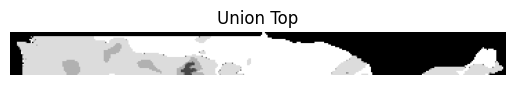

In [36]:
data0_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_90Part0_0/PredictionsConvolutionLSTM_forecast_31_90_Part0_0_w"+ventana4x4+".npy")
data0_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_1/PredictionsConvolutionLSTM_forecast_31_100_Part0_1_w"+ventana4x4+".npy")
data0_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_2/PredictionsConvolutionLSTM_forecast_31_100_Part0_2_w"+ventana4x4+".npy")
data0_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_3/PredictionsConvolutionLSTM_forecast_31_100_Part0_3_w"+ventana4x4+".npy")

print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
data0_0 = data0_0[:, :, :, :-4, :] # recorte del lado derecho
data0_1 = data0_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 00 recortada",data0_0.shape)
print("data 01 recortada",data0_1.shape)

#concatena los datos
combined_data0_1 = np.concatenate((data0_0, data0_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0_1.shape)

combined_data0_1 = combined_data0_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data0_1.shape)

data0_2 = data0_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 02 recortada",data0_2.shape)

#concatena los datos
combined_data0_2 = np.concatenate((combined_data0_1, data0_2), axis=3)

data0_3 = data0_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 03 recortada",data0_3.shape)

#concatena los datos
combined_data0_3 = np.concatenate((combined_data0_2, data0_3), axis=3)


# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data0_3.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data0_3[0,0], cmap='gray')
plt.title("Union Top")
plt.axis('off')
plt.show()

data 10 (370, 21, 41, 90, 1)
data 11 (370, 21, 41, 100, 1)
data 10 recortada (370, 21, 41, 86, 1)
data 11 recortada (370, 21, 41, 93, 1)
La forma de los datos combinados es: (370, 21, 41, 179, 1)
combined_data1_1 recortada (370, 21, 41, 175, 1)
data 12 recortada (370, 21, 41, 93, 1)
data 13 recortada (370, 21, 41, 92, 1)
La forma de los datos combinados es: (370, 21, 41, 360, 1)


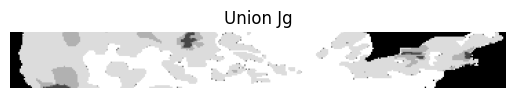

In [37]:
data1_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part1_0/PredictionsConvolutionLSTM_forecast_41_90_Part1_0_w"+ventana4x4+".npy")
data1_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_1/PredictionsConvolutionLSTM_forecast_41_100_Part1_1_w"+ventana4x4+".npy")
data1_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_2/PredictionsConvolutionLSTM_forecast_41_100_Part1_2_w"+ventana4x4+".npy")
data1_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_3/PredictionsConvolutionLSTM_forecast_41_100_Part1_3_w"+ventana4x4+".npy")

print("data 10",data1_0.shape)
print("data 11",data1_1.shape)
data1_0 = data1_0[:, :, :, :-4, :] # recorte del lado derecho
data1_1 = data1_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 10 recortada",data1_0.shape)
print("data 11 recortada",data1_1.shape)

#concatena los datos
combined_data1_1 = np.concatenate((data1_0, data1_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data1_1.shape)

combined_data1_1 = combined_data1_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data1_1 recortada",combined_data1_1.shape)

data1_2 = data1_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 12 recortada",data1_2.shape)

#concatena los datos
combined_data1_2 = np.concatenate((combined_data1_1, data1_2), axis=3)

data1_3 = data1_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 13 recortada",data1_3.shape)

#concatena los datos
combined_data1_3 = np.concatenate((combined_data1_2, data1_3), axis=3)


# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data1_3.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data1_3[0,0], cmap='gray')
plt.title("Union Jg")
plt.axis('off')
plt.show()

data 20 (370, 21, 41, 90, 1)
data 21 (370, 21, 41, 100, 1)
data 20 recortada (370, 21, 41, 86, 1)
data 21 recortada (370, 21, 41, 93, 1)
La forma de los datos combinados es: (370, 21, 41, 179, 1)
combined_data0 recortada (370, 21, 41, 175, 1)
data 22 recortada (370, 21, 41, 93, 1)
data 23 recortada (370, 21, 41, 92, 1)
La forma de los datos combinados es: (370, 21, 41, 360, 1)


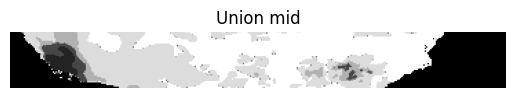

In [38]:
data2_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part2_0/PredictionsConvolutionLSTM_forecast_41_90_Part2_0_w"+ventana4x4+".npy")
data2_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_1/PredictionsConvolutionLSTM_forecast_41_100_Part2_1_w"+ventana4x4+".npy")
data2_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_2/PredictionsConvolutionLSTM_forecast_41_100_Part2_2_w"+ventana4x4+".npy")
data2_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_3/PredictionsConvolutionLSTM_forecast_41_100_Part2_3_w"+ventana4x4+".npy")

print("data 20",data2_0.shape)
print("data 21",data2_1.shape)
data2_0 = data2_0[:, :, :, :-4, :] # recorte del lado derecho
data2_1 = data2_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 20 recortada",data2_0.shape)
print("data 21 recortada",data2_1.shape)

#concatena los datos
combined_data2_1 = np.concatenate((data2_0, data2_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data2_1.shape)

combined_data2_1 = combined_data2_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data2_1.shape)

data2_2 = data2_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 22 recortada",data2_2.shape)

#concatena los datos
combined_data2_2 = np.concatenate((combined_data2_1, data2_2), axis=3)

data2_3 = data2_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 23 recortada",data2_3.shape)

#concatena los datos
combined_data2_3 = np.concatenate((combined_data2_2, data2_3), axis=3)


# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data2_3.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data2_3[0,0], cmap='gray')
plt.title("Union mid")
plt.axis('off')
plt.show()

data 30 (370, 21, 41, 90, 1)
data 31 (370, 21, 41, 100, 1)
data 30 recortada (370, 21, 41, 86, 1)
data 31 recortada (370, 21, 41, 93, 1)
La forma de los datos combinados es: (370, 21, 41, 179, 1)
combined_data0 recortada (370, 21, 41, 175, 1)
data 22 recortada (370, 21, 41, 93, 1)
data 23 recortada (370, 21, 41, 92, 1)
La forma de los datos combinados es: (370, 21, 41, 360, 1)


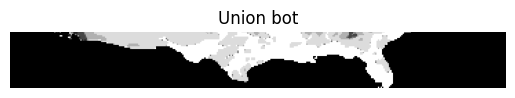

In [39]:
data3_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part3_0/PredictionsConvolutionLSTM_forecast_41_90_Part3_0_w"+ventana4x4+".npy")
data3_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_1/PredictionsConvolutionLSTM_forecast_41_100_Part3_1_w"+ventana4x4+".npy")
data3_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_2/PredictionsConvolutionLSTM_forecast_41_100_Part3_2_w"+ventana4x4+".npy")
data3_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_3/PredictionsConvolutionLSTM_forecast_41_100_Part3_3_w"+ventana4x4+".npy")

print("data 30",data3_0.shape)
print("data 31",data3_1.shape)
data3_0 = data3_0[:, :, :, :-4, :] # recorte del lado derecho
data3_1 = data3_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 30 recortada",data3_0.shape)
print("data 31 recortada",data3_1.shape)

#concatena los datos
combined_data3_1 = np.concatenate((data3_0, data3_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data3_1.shape)

combined_data3_1 = combined_data3_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data3_1.shape)

data3_2 = data3_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 22 recortada",data3_2.shape)

#concatena los datos
combined_data3_2 = np.concatenate((combined_data3_1, data3_2), axis=3)

data3_3 = data3_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 23 recortada",data3_3.shape)

#concatena los datos
combined_data3_3 = np.concatenate((combined_data3_2, data3_3), axis=3)


# La forma final esperada debería ser (371, 4, 41, 240, 1)
print("La forma de los datos combinados es:", combined_data3_3.shape)

# Guardar el array combinado
#output_path = "/path/to/combined_data.npy"
#np.save(output_path, combined_data)

#plot de la primera imagen
plt.imshow(combined_data3_3[0,0], cmap='gray')
plt.title("Union bot")
plt.axis('off')
plt.show()

data 00 (370, 21, 27, 360, 1)
data 01 (370, 21, 35, 360, 1)
La forma de los datos combinados es: (370, 21, 62, 360, 1)


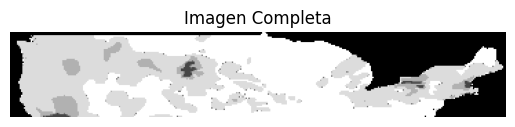

In [40]:
combined_data0_3 = combined_data0_3[:, :, :-4, :, ]
combined_data1_3 = combined_data1_3[:, :, 6:, :, ]
print("data 00",combined_data0_3.shape)
print("data 01",combined_data1_3.shape)

#concatena los datos
combined_data4x4TopJg = np.concatenate((combined_data0_3, combined_data1_3), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data4x4TopJg.shape)

plt.imshow(combined_data4x4TopJg[0,0], cmap='gray')
plt.title("Imagen Completa")
plt.axis('off')
plt.show()

# Guardar el array combinado
#np.save("DroughtDatasetMask/dataset/BordesNuevos/v10w10/imagenCompleta/imageComplete.npy", combined_data)

data 00 (370, 21, 58, 360, 1)
data 01 (370, 21, 34, 360, 1)
La forma de los datos combinados es: (370, 21, 92, 360, 1)


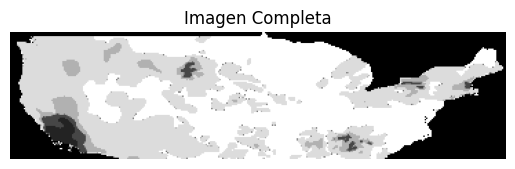

In [41]:
combined_data4x4TopJg = combined_data4x4TopJg[:, :, :-4, :, ]
combined_data2_3 = combined_data2_3[:, :, 7:, :, ]
print("data 00",combined_data4x4TopJg.shape)
print("data 01",combined_data2_3.shape)

#concatena los datos
combined_data4x4TopJgMid = np.concatenate((combined_data4x4TopJg, combined_data2_3), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data4x4TopJgMid.shape)

plt.imshow(combined_data4x4TopJgMid[0,0], cmap='gray')
plt.title("Imagen Completa")
plt.axis('off')
plt.show()

data 00 (370, 21, 88, 360, 1)
data 01 (370, 21, 34, 360, 1)
La forma de los datos combinados es: (370, 21, 122, 360, 1)


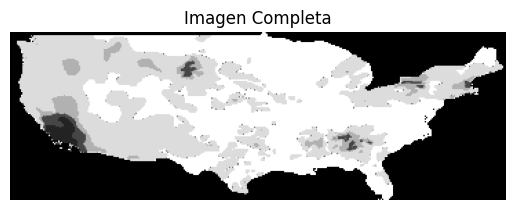

In [42]:
combined_data4x4TopJgMid = combined_data4x4TopJgMid[:, :, :-4, :, ]
combined_data3_3 = combined_data3_3[:, :, 7:, :, ]
print("data 00",combined_data4x4TopJgMid.shape)
print("data 01",combined_data3_3.shape)

#concatena los datos
combined_data4x4TopJgMidBot = np.concatenate((combined_data4x4TopJgMid, combined_data3_3), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data4x4TopJgMidBot.shape)

plt.imshow(combined_data4x4TopJgMidBot[0,0], cmap='gray')
plt.title("Imagen Completa")
plt.axis('off')
plt.show()


Guardar el npy

In [43]:
# Guardar el npy
np.save("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/imageComplete"+carpeta4x4+".npy", combined_data4x4TopJgMidBot)

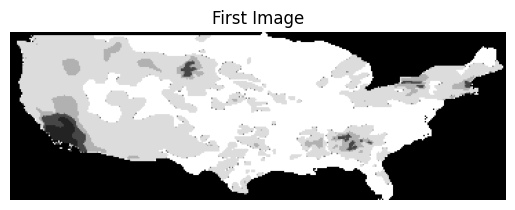

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy array
combined_data = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/imageComplete"+carpeta4x4+".npy")

# Display the first image
plt.imshow(combined_data[0, 0], cmap='gray')
plt.title("First Image")
plt.axis('off')
plt.show()


## Crear xtest y ytest 4x4

#### Xtest

In [45]:
data0_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_90Part0_0/x_test_mask.npy")
data0_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_1/x_test_mask.npy")
data0_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_2/x_test_mask.npy")
data0_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_3/x_test_mask.npy")

print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
data0_0 = data0_0[:, :, :, :-4, :] # recorte del lado derecho
data0_1 = data0_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 00 recortada",data0_0.shape)
print("data 01 recortada",data0_1.shape)

#concatena los datos
combined_data0_1 = np.concatenate((data0_0, data0_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0_1.shape)

combined_data0_1 = combined_data0_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data0_1.shape)

data0_2 = data0_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 02 recortada",data0_2.shape)

#concatena los datos
combined_data0_2 = np.concatenate((combined_data0_1, data0_2), axis=3)

data0_3 = data0_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 03 recortada",data0_3.shape)

#concatena los datos
combined_data0_3 = np.concatenate((combined_data0_2, data0_3), axis=3)

data1_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part1_0/x_test_mask.npy")
data1_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_1/x_test_mask.npy")
data1_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_2/x_test_mask.npy")
data1_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_3/x_test_mask.npy")

print("data 10",data1_0.shape)
print("data 11",data1_1.shape)
data1_0 = data1_0[:, :, :, :-4, :] # recorte del lado derecho
data1_1 = data1_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 10 recortada",data1_0.shape)
print("data 11 recortada",data1_1.shape)

#concatena los datos
combined_data1_1 = np.concatenate((data1_0, data1_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data1_1.shape)

combined_data1_1 = combined_data1_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data1_1 recortada",combined_data1_1.shape)

data1_2 = data1_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 12 recortada",data1_2.shape)

#concatena los datos
combined_data1_2 = np.concatenate((combined_data1_1, data1_2), axis=3)

data1_3 = data1_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 13 recortada",data1_3.shape)

#concatena los datos
combined_data1_3 = np.concatenate((combined_data1_2, data1_3), axis=3)

data2_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part2_0/x_test_mask.npy")
data2_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_1/x_test_mask.npy")
data2_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_2/x_test_mask.npy")
data2_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_3/x_test_mask.npy")

print("data 20",data2_0.shape)
print("data 21",data2_1.shape)
data2_0 = data2_0[:, :, :, :-4, :] # recorte del lado derecho
data2_1 = data2_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 20 recortada",data2_0.shape)
print("data 21 recortada",data2_1.shape)

#concatena los datos
combined_data2_1 = np.concatenate((data2_0, data2_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data2_1.shape)

combined_data2_1 = combined_data2_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data2_1.shape)

data2_2 = data2_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 22 recortada",data2_2.shape)

#concatena los datos
combined_data2_2 = np.concatenate((combined_data2_1, data2_2), axis=3)

data2_3 = data2_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 23 recortada",data2_3.shape)

#concatena los datos
combined_data2_3 = np.concatenate((combined_data2_2, data2_3), axis=3)

data3_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part3_0/x_test_mask.npy")
data3_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_1/x_test_mask.npy")
data3_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_2/x_test_mask.npy")
data3_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_3/x_test_mask.npy")

print("data 30",data3_0.shape)
print("data 31",data3_1.shape)
data3_0 = data3_0[:, :, :, :-4, :] # recorte del lado derecho
data3_1 = data3_1[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 30 recortada",data3_0.shape)
print("data 31 recortada",data3_1.shape)

#concatena los datos
combined_data3_1 = np.concatenate((data3_0, data3_1), axis=3)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data3_1.shape)

combined_data3_1 = combined_data3_1[:, :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data3_1.shape)

data3_2 = data3_2[:, :, :, 7:, :] # recorte del lado izquierdo
print("data 22 recortada",data3_2.shape)

#concatena los datos
combined_data3_2 = np.concatenate((combined_data3_1, data3_2), axis=3)

data3_3 = data3_3[:, :, :, 8:, :] # recorte del lado izquierdo
print("data 23 recortada",data3_3.shape)

#concatena los datos
combined_data3_3 = np.concatenate((combined_data3_2, data3_3), axis=3)

###########

combined_data0_3 = combined_data0_3[:, :, :-4, :, ]
combined_data1_3 = combined_data1_3[:, :, 6:, :, ]
print("data 00",combined_data0_3.shape)
print("data 01",combined_data1_3.shape)

#concatena los datos
combined_data4x4TopJg = np.concatenate((combined_data0_3, combined_data1_3), axis=2)

combined_data4x4TopJg = combined_data4x4TopJg[:, :, :-4, :, ]
combined_data2_3 = combined_data2_3[:, :, 7:, :, ]
print("data 00",combined_data4x4TopJg.shape)
print("data 01",combined_data2_3.shape)

#concatena los datos
combined_data4x4TopJgMid = np.concatenate((combined_data4x4TopJg, combined_data2_3), axis=2)

combined_data4x4TopJgMid = combined_data4x4TopJgMid[:, :, :-4, :, ]
combined_data3_3 = combined_data3_3[:, :, 7:, :, ]
print("data 00",combined_data4x4TopJgMid.shape)
print("data 01",combined_data3_3.shape)

#concatena los datos
combined_data4x4TopJgMidBot = np.concatenate((combined_data4x4TopJgMid, combined_data3_3), axis=2)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data4x4TopJgMidBot.shape)

# Guardar el npy
np.save("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/XtestImageComplete"+carpeta4x4+".npy", combined_data4x4TopJgMidBot)

data 00 (370, 21, 31, 90, 1)
data 01 (370, 21, 31, 100, 1)
data 00 recortada (370, 21, 31, 86, 1)
data 01 recortada (370, 21, 31, 93, 1)
La forma de los datos combinados es: (370, 21, 31, 179, 1)
combined_data0 recortada (370, 21, 31, 175, 1)
data 02 recortada (370, 21, 31, 93, 1)
data 03 recortada (370, 21, 31, 92, 1)
data 10 (370, 21, 41, 90, 1)
data 11 (370, 21, 41, 100, 1)
data 10 recortada (370, 21, 41, 86, 1)
data 11 recortada (370, 21, 41, 93, 1)
La forma de los datos combinados es: (370, 21, 41, 179, 1)
combined_data1_1 recortada (370, 21, 41, 175, 1)
data 12 recortada (370, 21, 41, 93, 1)
data 13 recortada (370, 21, 41, 92, 1)
data 20 (370, 21, 41, 90, 1)
data 21 (370, 21, 41, 100, 1)
data 20 recortada (370, 21, 41, 86, 1)
data 21 recortada (370, 21, 41, 93, 1)
La forma de los datos combinados es: (370, 21, 41, 179, 1)
combined_data0 recortada (370, 21, 41, 175, 1)
data 22 recortada (370, 21, 41, 93, 1)
data 23 recortada (370, 21, 41, 92, 1)
data 30 (370, 21, 41, 90, 1)
data 3

#### Ytest

In [46]:
data0_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_90Part0_0/y_test_mask.npy")
data0_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_1/y_test_mask.npy")
data0_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_2/y_test_mask.npy")
data0_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/31_100Part0_3/y_test_mask.npy")

print("data 00",data0_0.shape)
print("data 01",data0_1.shape)
data0_0 = data0_0[ :, :, :-4, :] # recorte del lado derecho
data0_1 = data0_1[ :, :, 7:, :] # recorte del lado izquierdo
print("data 00 recortada",data0_0.shape)
print("data 01 recortada",data0_1.shape)

#concatena los datos
combined_data0_1 = np.concatenate((data0_0, data0_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data0_1.shape)

combined_data0_1 = combined_data0_1[ :, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data0_1.shape)

data0_2 = data0_2[ :, :, 7:, :] # recorte del lado izquierdo
print("data 02 recortada",data0_2.shape)

#concatena los datos
combined_data0_2 = np.concatenate((combined_data0_1, data0_2), axis=2)

data0_3 = data0_3[:, :, 8:, :] # recorte del lado izquierdo
print("data 03 recortada",data0_3.shape)

#concatena los datos
combined_data0_3 = np.concatenate((combined_data0_2, data0_3), axis=2)

data1_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part1_0/y_test_mask.npy")
data1_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_1/y_test_mask.npy")
data1_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_2/y_test_mask.npy")
data1_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part1_3/y_test_mask.npy")

print("data 10",data1_0.shape)
print("data 11",data1_1.shape)
data1_0 = data1_0[:, :, :-4, :] # recorte del lado derecho
data1_1 = data1_1[:, :, 7:, :] # recorte del lado izquierdo
print("data 10 recortada",data1_0.shape)
print("data 11 recortada",data1_1.shape)

#concatena los datos
combined_data1_1 = np.concatenate((data1_0, data1_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data1_1.shape)

combined_data1_1 = combined_data1_1[:, :, :-4, :] # recorte del lado derecho
print ("combined_data1_1 recortada",combined_data1_1.shape)

data1_2 = data1_2[:, :, 7:, :] # recorte del lado izquierdo
print("data 12 recortada",data1_2.shape)

#concatena los datos
combined_data1_2 = np.concatenate((combined_data1_1, data1_2), axis=2)

data1_3 = data1_3[:, :, 8:, :] # recorte del lado izquierdo
print("data 13 recortada",data1_3.shape)

#concatena los datos
combined_data1_3 = np.concatenate((combined_data1_2, data1_3), axis=2)

data2_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part2_0/y_test_mask.npy")
data2_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_1/y_test_mask.npy")
data2_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_2/y_test_mask.npy")
data2_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part2_3/y_test_mask.npy")

print("data 20",data2_0.shape)
print("data 21",data2_1.shape)
data2_0 = data2_0[:, :, :-4, :] # recorte del lado derecho
data2_1 = data2_1[:, :, 7:, :] # recorte del lado izquierdo
print("data 20 recortada",data2_0.shape)
print("data 21 recortada",data2_1.shape)

#concatena los datos
combined_data2_1 = np.concatenate((data2_0, data2_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data2_1.shape)

combined_data2_1 = combined_data2_1[:, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data2_1.shape)

data2_2 = data2_2[:, :, 7:, :] # recorte del lado izquierdo
print("data 22 recortada",data2_2.shape)

#concatena los datos
combined_data2_2 = np.concatenate((combined_data2_1, data2_2), axis=2)

data2_3 = data2_3[:, :, 8:, :] # recorte del lado izquierdo
print("data 23 recortada",data2_3.shape)

#concatena los datos
combined_data2_3 = np.concatenate((combined_data2_2, data2_3), axis=2)

data3_0 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_90Part3_0/y_test_mask.npy")
data3_1 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_1/y_test_mask.npy")
data3_2 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_2/y_test_mask.npy")
data3_3 = np.load("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/41_100Part3_3/y_test_mask.npy")

print("data 30",data3_0.shape)
print("data 31",data3_1.shape)
data3_0 = data3_0[:, :, :-4, :] # recorte del lado derecho
data3_1 = data3_1[:, :, 7:, :] # recorte del lado izquierdo
print("data 30 recortada",data3_0.shape)
print("data 31 recortada",data3_1.shape)

#concatena los datos
combined_data3_1 = np.concatenate((data3_0, data3_1), axis=2)

# La forma final esperada debería ser (371, 4, 61, 360, 1)
print("La forma de los datos combinados es:", combined_data3_1.shape)

combined_data3_1 = combined_data3_1[:, :, :-4, :] # recorte del lado derecho
print ("combined_data0 recortada",combined_data3_1.shape)

data3_2 = data3_2[:, :, 7:, :] # recorte del lado izquierdo
print("data 22 recortada",data3_2.shape)

#concatena los datos
combined_data3_2 = np.concatenate((combined_data3_1, data3_2), axis=2)

data3_3 = data3_3[:, :, 8:, :] # recorte del lado izquierdo
print("data 23 recortada",data3_3.shape)

#concatena los datos
combined_data3_3 = np.concatenate((combined_data3_2, data3_3), axis=2)

###########

combined_data0_3 = combined_data0_3[:, :-4, :, ]
combined_data1_3 = combined_data1_3[:, 6:, :, ]
print("data 00",combined_data0_3.shape)
print("data 01",combined_data1_3.shape)

#concatena los datos
combined_data4x4TopJg = np.concatenate((combined_data0_3, combined_data1_3), axis=1)

combined_data4x4TopJg = combined_data4x4TopJg[:, :-4, :, ]
combined_data2_3 = combined_data2_3[:, 7:, :, ]
print("data 00",combined_data4x4TopJg.shape)
print("data 01",combined_data2_3.shape)

#concatena los datos
combined_data4x4TopJgMid = np.concatenate((combined_data4x4TopJg, combined_data2_3), axis=1)

combined_data4x4TopJgMid = combined_data4x4TopJgMid[:, :-4, :, ]
combined_data3_3 = combined_data3_3[:, 7:, :, ]
print("data 00",combined_data4x4TopJgMid.shape)
print("data 01",combined_data3_3.shape)

#concatena los datos
combined_data4x4TopJgMidBot = np.concatenate((combined_data4x4TopJgMid, combined_data3_3), axis=1)

# La forma final esperada debería ser (371, 4, 122, 360, 1)
print("La forma de los datos combinados es:", combined_data4x4TopJgMidBot.shape)

# Guardar el npy
np.save("DroughtDatasetMask/dataset/Resultados4x4/"+carpeta4x4+"/ytestImageComplete"+carpeta4x4+".npy", combined_data4x4TopJgMidBot)

data 00 (370, 31, 90, 1)
data 01 (370, 31, 100, 1)
data 00 recortada (370, 31, 86, 1)
data 01 recortada (370, 31, 93, 1)
La forma de los datos combinados es: (370, 31, 179, 1)
combined_data0 recortada (370, 31, 175, 1)
data 02 recortada (370, 31, 93, 1)
data 03 recortada (370, 31, 92, 1)
data 10 (370, 41, 90, 1)
data 11 (370, 41, 100, 1)
data 10 recortada (370, 41, 86, 1)
data 11 recortada (370, 41, 93, 1)
La forma de los datos combinados es: (370, 41, 179, 1)
combined_data1_1 recortada (370, 41, 175, 1)
data 12 recortada (370, 41, 93, 1)
data 13 recortada (370, 41, 92, 1)
data 20 (370, 41, 90, 1)
data 21 (370, 41, 100, 1)
data 20 recortada (370, 41, 86, 1)
data 21 recortada (370, 41, 93, 1)
La forma de los datos combinados es: (370, 41, 179, 1)
combined_data0 recortada (370, 41, 175, 1)
data 22 recortada (370, 41, 93, 1)
data 23 recortada (370, 41, 92, 1)
data 30 (370, 41, 90, 1)
data 31 (370, 41, 100, 1)
data 30 recortada (370, 41, 86, 1)
data 31 recortada (370, 41, 93, 1)
La forma d